# WBIC

This notebook gives a tutorial on how to use Watanabe-Bayesian information criterion (WBIC) for feature selection. The WBIC is an information criterion. Similarly to other criteria (AIC, BIC, DIC) the WBIC endeavors to find the most parsimonious model, i.e., the model that balances fit with complexity. In other words a model (or set of features) that optimizes WBIC should neither over nor under fit the available data. 

In this tutorial a data set is simulated using the damped linear trend (DLT) model. This data set is then used to fit DLT models with varying number of features as well as a global local trent model (GLT), and a Error-Trend-Seasonal (ETS) model. The WBIC criteria is then show to find the true model. 


In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
print(orbit.__version__)
from orbit.models import DLT,ETS, KTRLite, LGT
from orbit.utils.simulation import make_trend, make_regression

print(orbit.__version__)

%load_ext autoreload
%autoreload 2

1.1.0dev
1.1.0dev


In [2]:
pwd()

'/Users/gavin.steininger/Desktop/WBIC_pyro/orbit/examples'

## Simulated Data

This block of code creats random data set (365 observations with 10 features) assuming a DLT model. Of the 10 features 5 are effective regressors; i.e., they are used in the true model to create the data.

As an exerise left to the user once you have run the code once try changing the NUM_OF_EFFECTIVE_REGRESSORS (line 2), the SERIES_LEN (line 3), and the SEED (line 4) to see how it effects the results. 

In [60]:
NUM_OF_REGRESSORS = 10
NUM_OF_EFFECTIVE_REGRESSORS = 5
SERIES_LEN = 365
SEED = 1
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

# combine trend and the regression
y = trend + regression
y = y - y.min()


x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)
print(x.shape)

x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
print(df.shape)
print(df.head())



(365,) (365, 5)
(365, 10)
(365, 12)
          y        x1        x2        x3        x4        x5        x6  \
0  3.192673  0.172792  0.000000  0.165219 -0.000000  0.452678  0.300982   
1  3.951436  0.223187 -0.000000  0.290559  0.182286  0.147066 -2.305943   
2  4.122889  0.014211  0.273356 -0.368227 -0.081455 -0.241060  1.033964   
3  1.669311  0.299423  0.019861 -0.146228 -0.390954 -0.128596  0.997292   
4  3.567194  0.004071 -0.137801  0.647032  0.000000 -0.000000 -0.567218   

         x7        x8        x9       x10       date  
0  0.540297  0.373497  0.377813 -0.090213 2016-01-10  
1  1.142760 -1.535654 -0.863752  1.016545 2016-01-17  
2 -0.824492  0.018905 -0.383344 -0.304185 2016-01-24  
3 -0.127274 -1.475886 -1.940906  0.833649 2016-01-31  
4  1.174487  0.319069  0.190870  0.369270 2016-02-07  


This section of code fits the DLT model to the simulated data for each number of features. 

In [61]:
WBIC_ls = []
for k in range(0, NUM_OF_REGRESSORS):
    regressor_col = x_cols[:k + 1]
    dlt_mod = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
        )
    WBIC_temp = dlt_mod.fit_wbic(df=df) 
    print(k)
    print(WBIC_temp)
    print('------------------------------------------------------------------')
    WBIC_ls.append(WBIC_temp)

    


Gradient evaluation took 0.000719 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.19 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000696 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000673 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000968 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.68 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0
1198.1800976963348
------------------------------------------------------------------

Gradient evaluation took 0.000783 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000713 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.13 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.001009 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.09 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.001015 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.15 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  60

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1
1126.249783978133
------------------------------------------------------------------

Gradient evaluation took 0.000783 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000862 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.62 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000672 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000716 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.16 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 /

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
1117.2318404578557
------------------------------------------------------------------

Gradient evaluation took 0.000681 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.81 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000672 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000637 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.37 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


3
1052.2484457584642
------------------------------------------------------------------

Gradient evaluation took 0.000698 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000719 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.19 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000689 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.89 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


4
1051.9229011183613
------------------------------------------------------------------

Gradient evaluation took 0.00071 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00075 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000746 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.46 seconds.

Adjust your expectations accordingly!


Gradient evaluation took 0.000943 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.43 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  200 / 20

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
1055.5511322382667
------------------------------------------------------------------

Gradient evaluation took 0.000692 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.92 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000719 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.19 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000671 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000804 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.04 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  200 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


6
1062.2155295925531
------------------------------------------------------------------

Gradient evaluation took 0.000845 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000843 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001079 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000708 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.08 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
1068.1199765366707
------------------------------------------------------------------

Gradient evaluation took 0.00073 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000744 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000865 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000777 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.77 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


8
1073.6494919599825
------------------------------------------------------------------

Gradient evaluation took 0.000686 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000784 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000677 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.77 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000772 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.72 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


9
1080.2645605950854
------------------------------------------------------------------


The plot below shows the WBIC vs the number of features (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value.

Text(0.5, 0, '# number of Features')

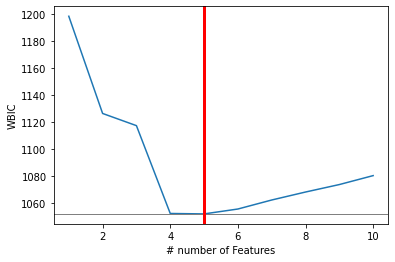

In [62]:
num_reg_ls = list(range(1, NUM_OF_REGRESSORS+1))
plt.plot(num_reg_ls, WBIC_ls, )
plt.axhline(y=min(WBIC_ls), color='grey', linewidth = 1)
plt.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS, color='red', linewidth = 3)
plt.ylabel("WBIC")
plt.xlabel("# number of Features")

In [63]:
print(np.argmin(WBIC_ls))
WBIC_ls

4


[1198.1800976963348,
 1126.249783978133,
 1117.2318404578557,
 1052.2484457584642,
 1051.9229011183613,
 1055.5511322382667,
 1062.2155295925531,
 1068.1199765366707,
 1073.6494919599825,
 1080.2645605950854]

The next block of code tests the WBIC with different random seeds. This code can be very slow! 

In [65]:
works_ls = []
for i in range(0,10):
    NUM_OF_REGRESSORS = 6
    NUM_OF_EFFECTIVE_REGRESSORS = 3
    SERIES_LEN = 365
    SEED = 1+i
    # sample some coefficients
    COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
    trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
    x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
    print(regression.shape, x.shape)
    
    # combine trend and the regression
    y = trend + regression
    y = y - y.min()
    
    
    x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
    x = np.concatenate([x, x_extra], axis=-1)
    
    x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
    response_col = "y"
    dt_col = "date"
    obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
    # make a data frame for orbit inputs
    df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
    # make some dummy date stamp
    dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
    df['date'] = dt

    WBIC_ls = []
    for k in range(0, NUM_OF_REGRESSORS):
        regressor_col = x_cols[:k + 1]
        dlt_mod = DLT(
            response_col=response_col,
            date_col=dt_col,
            regressor_col=regressor_col,
            seed=2022,
            # fixing the smoothing parameters to learn regression coefficients more effectively
            level_sm_input=0.01,
            slope_sm_input=0.01,
            num_warmup=1000,
            num_sample=1000,
            )
        WBIC_temp = dlt_mod.fit_wbic(df=df)
        print(i)
        print(k)
        print(WBIC_temp)
        print('------------------------------------------------------------------')
        WBIC_ls.append(WBIC_temp)
    
    works_temp = (np.argmin(WBIC_ls)+ 1) == NUM_OF_EFFECTIVE_REGRESSORS    
    works_ls.append(works_temp)
    print('------------------------------------------------------------------')
    print(i)
    print(works_ls)
    print(WBIC_ls)
    print('------------------------------------------------------------------')
        

    
    

(365,) (365, 3)

Gradient evaluation took 0.000772 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000634 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00066 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00062 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.2 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration: 100 / 500 [ 20%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0
0
1137.51699579378
------------------------------------------------------------------

Gradient evaluation took 0.000685 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000624 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.24 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000653 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00066 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.6 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 15.0786 seconds (Warm-up)
               0.765541 seconds (Sampling)
               15.8441 seconds (Total)

0
1
1083.9628914254424
------------------------------------------------------------------

Gradient evaluation took 0.000903 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.03 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000708 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000702 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000744 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.44 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.5536 seconds (Warm-up)
               0.863741 seconds (Sampling)
               15.4174 seconds (Total)

0
2
1047.8246333951606
------------------------------------------------------------------

Gradient evaluation took 0.00081 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001096 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001151 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000881 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.81 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0
3
1053.6588793530823
------------------------------------------------------------------

Gradient evaluation took 0.000687 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.87 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000679 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000807 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000786 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.86 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.8673 seconds (Warm-up)
               0.953381 seconds (Sampling)
               15.8206 seconds (Total)

0
4
1055.0523350907276
------------------------------------------------------------------

Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000687 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.87 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000817 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.17 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000632 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.32 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.3347 seconds (Warm-up)
               0.724808 seconds (Sampling)
               14.0596 seconds (Total)

0
5
1060.1585448210249
------------------------------------------------------------------
------------------------------------------------------------------
0
[True]
[1137.51699579378, 1083.9628914254424, 1047.8246333951606, 1053.6588793530823, 1055.0523350907276, 1060.1585448210249]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000744 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000642 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000647 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.47 seconds.
Adjust your exp

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.139 seconds (Warm-up)
               0.677416 seconds (Sampling)
               14.8164 seconds (Total)

1
0
1069.7804538618807
------------------------------------------------------------------

Gradient evaluation took 0.000779 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000742 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000688 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.88 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000721 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 15.5268 seconds (Warm-up)
               0.695488 seconds (Sampling)
               16.2223 seconds (Total)

1
1
1062.6770883006068
------------------------------------------------------------------

Gradient evaluation took 0.000691 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000675 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000678 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000764 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.64 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.9717 seconds (Warm-up)
               0.841342 seconds (Sampling)
               14.813 seconds (Total)

1
2
1045.4453297317275
------------------------------------------------------------------

Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000656 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000664 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000689 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.89 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1
3
1051.0687827884988
------------------------------------------------------------------

Gradient evaluation took 0.000709 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.09 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00097 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000794 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.94 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000811 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.11 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1
4
1057.3929052402952
------------------------------------------------------------------

Gradient evaluation took 0.000714 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000795 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000702 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000633 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.33 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1
5
1060.4110787632749
------------------------------------------------------------------
------------------------------------------------------------------
1
[True, True]
[1069.7804538618807, 1062.6770883006068, 1045.4453297317275, 1051.0687827884988, 1057.3929052402952, 1060.4110787632749]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000625 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.25 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000801 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.01 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000713 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000632 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.32 seconds.
Adjust y

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
0
1075.8927025092435
------------------------------------------------------------------

Gradient evaluation took 0.000802 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000682 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000644 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000648 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.48 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
1
1061.6108868068748
------------------------------------------------------------------

Gradient evaluation took 0.000665 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000656 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000705 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.05 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000625 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.25 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
2
1043.416988920292
------------------------------------------------------------------

Gradient evaluation took 0.00076 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.6 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000688 seconds
Gradient evaluation took 0.000663 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.88 seconds.
1000 transitions using 10 leapfrog steps per transition would take 6.63 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 0.000643 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.43 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
3
1050.0705690413552
------------------------------------------------------------------

Gradient evaluation took 0.000806 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000671 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000673 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000725 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.25 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
4
1057.909351873649
------------------------------------------------------------------

Gradient evaluation took 0.000691 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000693 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000653 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000831 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.31 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
5
1060.7373251393105
------------------------------------------------------------------
------------------------------------------------------------------
2
[True, True, True]
[1075.8927025092435, 1061.6108868068748, 1043.416988920292, 1050.0705690413552, 1057.909351873649, 1060.7373251393105]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000622 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000628 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000637 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.37 seconds.
Adju

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.0395 seconds (Warm-up)
               0.751775 seconds (Sampling)
               13.7913 seconds (Total)

3
0
1089.94363967022
------------------------------------------------------------------

Gradient evaluation took 0.000711 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Adjust your expectations accordingly!

Gradient evaluation took 0.001005 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.05 seconds.
Adjust your expectations accordingly!





Gradient evaluation took 0.00075 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001345 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.45 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


3
1
1097.1299416628217
------------------------------------------------------------------

Gradient evaluation took 0.000675 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000702 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000806 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000734 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.34 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.6761 seconds (Warm-up)
               0.879987 seconds (Sampling)
               15.5561 seconds (Total)

3
2
1048.3921242208357
------------------------------------------------------------------

Gradient evaluation took 0.000674 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.74 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000876 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.76 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001309 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.09 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.983 seconds (Warm-up)
               0.7109 seconds (Sampling)
               15.6939 seconds (Total)

3
3
1055.1487827599249
------------------------------------------------------------------

Gradient evaluation took 0.000722 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00065 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000761 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000654 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.54 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


3
4
1060.07883465315
------------------------------------------------------------------

Gradient evaluation took 0.00065 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000667 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000697 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.97 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000848 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.48 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


3
5
1063.4505878573184
------------------------------------------------------------------
------------------------------------------------------------------
3
[True, True, True, True]
[1089.94363967022, 1097.1299416628217, 1048.3921242208357, 1055.1487827599249, 1060.07883465315, 1063.4505878573184]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000655 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000644 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000679 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.6321 seconds (Warm-up)
               0.755036 seconds (Sampling)
               14.3871 seconds (Total)

4
0
1066.9631049018558
------------------------------------------------------------------

Gradient evaluation took 0.000671 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.71 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000686 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000656 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.56 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


4
1
1040.430780884733
------------------------------------------------------------------

Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00066 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000623 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.23 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000663 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.63 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (W

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


4
2
1047.6627168462876
------------------------------------------------------------------

Gradient evaluation took 0.000812 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000845 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000711 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00067 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.7 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.6155 seconds (Warm-up)
               0.790346 seconds (Sampling)
               14.4059 seconds (Total)

4
3
1054.8063107595783
------------------------------------------------------------------

Gradient evaluation took 0.000761 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.61 seconds.

Gradient evaluation took 0.000636 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.36 seconds.
Adjust your expectations accordingly!


Adjust your expectations accordingly!



Gradient evaluation took 0.000664 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000657 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.57 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


4
4
1060.2082754688813
------------------------------------------------------------------


Gradient evaluation took 0.000657 seconds
Gradient evaluation took 0.000615 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.57 seconds.
1000 transitions using 10 leapfrog steps per transition would take 6.15 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 0.000633 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.33 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000657 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.57 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.8765 seconds (Warm-up)
               0.755343 seconds (Sampling)
               14.6319 seconds (Total)

4
5
1064.2868975511558
------------------------------------------------------------------
------------------------------------------------------------------
4
[True, True, True, True, False]
[1066.9631049018558, 1040.430780884733, 1047.6627168462876, 1054.8063107595783, 1060.2082754688813, 1064.2868975511558]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000624 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.24 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000881 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.81 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000629 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
0
1047.3443933673857
------------------------------------------------------------------

Gradient evaluation took 0.000722 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000632 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00064 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000932 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.32 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 16.0546 seconds (Warm-up)
               1.05407 seconds (Sampling)
               17.1086 seconds (Total)

5
1
1047.8939190758708
------------------------------------------------------------------

Gradient evaluation took 0.000634 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000645 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000729 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.29 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
2
1046.6752659820718
------------------------------------------------------------------

Gradient evaluation took 0.000836 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.36 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000714 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000733 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.33 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
3
1052.1403316135597
------------------------------------------------------------------

Gradient evaluation took 0.000669 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000667 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000803 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.03 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00067 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.7 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
4
1055.858925287209
------------------------------------------------------------------

Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000687 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.87 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000621 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.21 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
5
1061.6031747431784
------------------------------------------------------------------
------------------------------------------------------------------
5
[True, True, True, True, False, True]
[1047.3443933673857, 1047.8939190758708, 1046.6752659820718, 1052.1403316135597, 1055.858925287209, 1061.6031747431784]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000632 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000696 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000623 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.23 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would tak

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


6
0
1092.6029581144774
------------------------------------------------------------------

Gradient evaluation took 0.000739 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00071 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000748 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000801 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.01 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration: 100 / 500 [ 20%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 15.9828 seconds (Warm-up)
               0.684029 seconds (Sampling)
               16.6668 seconds (Total)

6
1
1059.3848162910492
------------------------------------------------------------------

Gradient evaluation took 0.000719 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.19 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001359 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000935 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000686 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


6
2
1047.0740325085435
------------------------------------------------------------------

Gradient evaluation took 0.000652 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000781 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.81 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000712 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.12 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


6
3
1050.9415049119987
------------------------------------------------------------------

Gradient evaluation took 0.000645 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000659 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000673 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.73 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 15.1282 seconds (Warm-up)
               1.29218 seconds (Sampling)
               16.4204 seconds (Total)

6
4
1058.455742203153
------------------------------------------------------------------

Gradient evaluation took 0.000647 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000652 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000619 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.19 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


6
5
1061.8404607480422
------------------------------------------------------------------
------------------------------------------------------------------
6
[True, True, True, True, False, True, True]
[1092.6029581144774, 1059.3848162910492, 1047.0740325085435, 1050.9415049119987, 1058.455742203153, 1061.8404607480422]
------------------------------------------------------------------
(365,) (365, 3)


Gradient evaluation took 0.000653 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.53 seconds.
Adjust your expectations accordingly!

Gradient evaluation took 0.000626 seconds


1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Gradient evaluation took 0.00063 seconds
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 6.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000604 seconds
1000 transitions using 10 leapfrog steps per transition would

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
0
1118.3844741351886
------------------------------------------------------------------

Gradient evaluation took 0.000783 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000725 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.25 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000717 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.17 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000647 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.47 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
1
1053.3257729028703
------------------------------------------------------------------

Gradient evaluation took 0.000876 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.76 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000764 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000657 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001189 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.89 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
2
1047.005225248187
------------------------------------------------------------------

Gradient evaluation took 0.000737 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.37 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000721 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000835 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000676 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.76 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.0171 seconds (Warm-up)
               0.707989 seconds (Sampling)
               13.7251 seconds (Total)

7
3
1053.4479758665473
------------------------------------------------------------------

Gradient evaluation took 0.000665 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000616 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.16 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000748 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000659 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
4
1060.3679985030644
------------------------------------------------------------------

Gradient evaluation took 0.000761 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000778 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00085 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.5 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


7
5
1064.112550376051
------------------------------------------------------------------
------------------------------------------------------------------
7
[True, True, True, True, False, True, True, True]
[1118.3844741351886, 1053.3257729028703, 1047.005225248187, 1053.4479758665473, 1060.3679985030644, 1064.112550376051]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000732 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000608 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000637 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.37 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00062 seconds
1000 transitions using 10 leapfrog steps per transition 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.9791 seconds (Warm-up)
               0.755035 seconds (Sampling)
               14.7341 seconds (Total)

8
0
1049.8648910322502
------------------------------------------------------------------


Gradient evaluation took 0.00064 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.4 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000651 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000648 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000627 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.27 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 12.662 seconds (Warm-up)
               0.711161 seconds (Sampling)
               13.3731 seconds (Total)

8
1
1043.798498244468
------------------------------------------------------------------

Gradient evaluation took 0.000861 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000711 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000631 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000695 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.95 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


8
2
1045.940964215169
------------------------------------------------------------------

Gradient evaluation took 0.000696 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000767 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000756 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000639 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.39 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 12.8412 seconds (Warm-up)
               0.774452 seconds (Sampling)
               13.6156 seconds (Total)

8
3
1053.5467203816697
------------------------------------------------------------------


Gradient evaluation took 0.000885 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.85 seconds.
Gradient evaluation took 0.000721 seconds
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00073 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000639 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.39 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


8
4
1059.7100000097591
------------------------------------------------------------------

Gradient evaluation took 0.000846 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000652 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000721 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000743 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.43 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


8
5
1063.9270477853502
------------------------------------------------------------------
------------------------------------------------------------------
8
[True, True, True, True, False, True, True, True, False]
[1049.8648910322502, 1043.798498244468, 1045.940964215169, 1053.5467203816697, 1059.7100000097591, 1063.9270477853502]
------------------------------------------------------------------
(365,) (365, 3)

Gradient evaluation took 0.000629 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.29 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00085 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000863 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001079 seconds
1000 transitions using 10 leapfrog steps per tran

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 13.1446 seconds (Warm-up)
               0.682238 seconds (Sampling)
               13.8269 seconds (Total)

9
0
1086.526913133208
------------------------------------------------------------------

Gradient evaluation took 0.000647 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00065 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000964 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000948 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.48 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 /

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 12.939 seconds (Warm-up)
               0.704304 seconds (Sampling)
               13.6433 seconds (Total)

9
1
1067.5859144605145
------------------------------------------------------------------

Gradient evaluation took 0.000646 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000628 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000852 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.52 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 14.9517 seconds (Warm-up)
               0.739187 seconds (Sampling)
               15.6909 seconds (Total)

9
2
1048.6200050219043
------------------------------------------------------------------

Gradient evaluation took 0.000681 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.81 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00076 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000713 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000892 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.92 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 500 / 500 [100%]  (Sampling)

 Elapsed Time: 12.6928 seconds (Warm-up)
               0.794985 seconds (Sampling)
               13.4877 seconds (Total)

9
3
1054.0384813504281
------------------------------------------------------------------

Gradient evaluation took 0.00094 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000745 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000736 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.36 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000833 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.33 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


9
4
1058.5926259357395
------------------------------------------------------------------

Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000801 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.01 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000654 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.54 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


9
5
1063.3349937201906
------------------------------------------------------------------
------------------------------------------------------------------
9
[True, True, True, True, False, True, True, True, False, True]
[1086.526913133208, 1067.5859144605145, 1048.6200050219043, 1054.0384813504281, 1058.5926259357395, 1063.3349937201906]
------------------------------------------------------------------


In [ ]:
sum(works_ls)